# Data Analytics Project - Models

# Pair 4 - TATAMTRDVR LSTM

---

# 1. Import required modules

In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


---

# 2. Get Pair 4 Orders Dataset

## 2.1. Get the orders

In [2]:
orders_df = pd.read_csv('../../Preprocess/Pair4/Pair4_orders.csv')
orders_df.head()

,Date,ASHOKLEY_Close,TATAMTRDVR_Close,Spread,zscore,Orders
0,2019-05-17,84.500000,83.199997,1.300003,-1.764996,LONG
1,2019-05-20,87.550003,88.849998,-1.299995,-2.747445,LONG
2,2019-05-21,88.250000,83.150002,5.099998,-0.329109,FLAT
3,2019-05-22,87.849998,85.400002,2.449997,-1.330453,FLAT
4,2019-05-23,88.849998,84.849998,4.000000,-0.744760,FLAT


In [3]:
orders_df.tail()

,Date,ASHOKLEY_Close,TATAMTRDVR_Close,Spread,zscore,Orders
57,2019-08-07,61.150002,55.650002,5.500000,-0.177963,FLAT
58,2019-08-08,63.549999,58.750000,4.799999,-0.442469,FLAT
59,2019-08-09,64.300003,58.200001,6.100002,0.048757,FLAT
60,2019-08-13,61.549999,57.700001,3.849998,-0.801441,FLAT
61,2019-08-14,62.549999,57.349998,5.200001,-0.291322,FLAT


## 2.2. Visualize the orders

Text(0, 0.5, 'zscore')

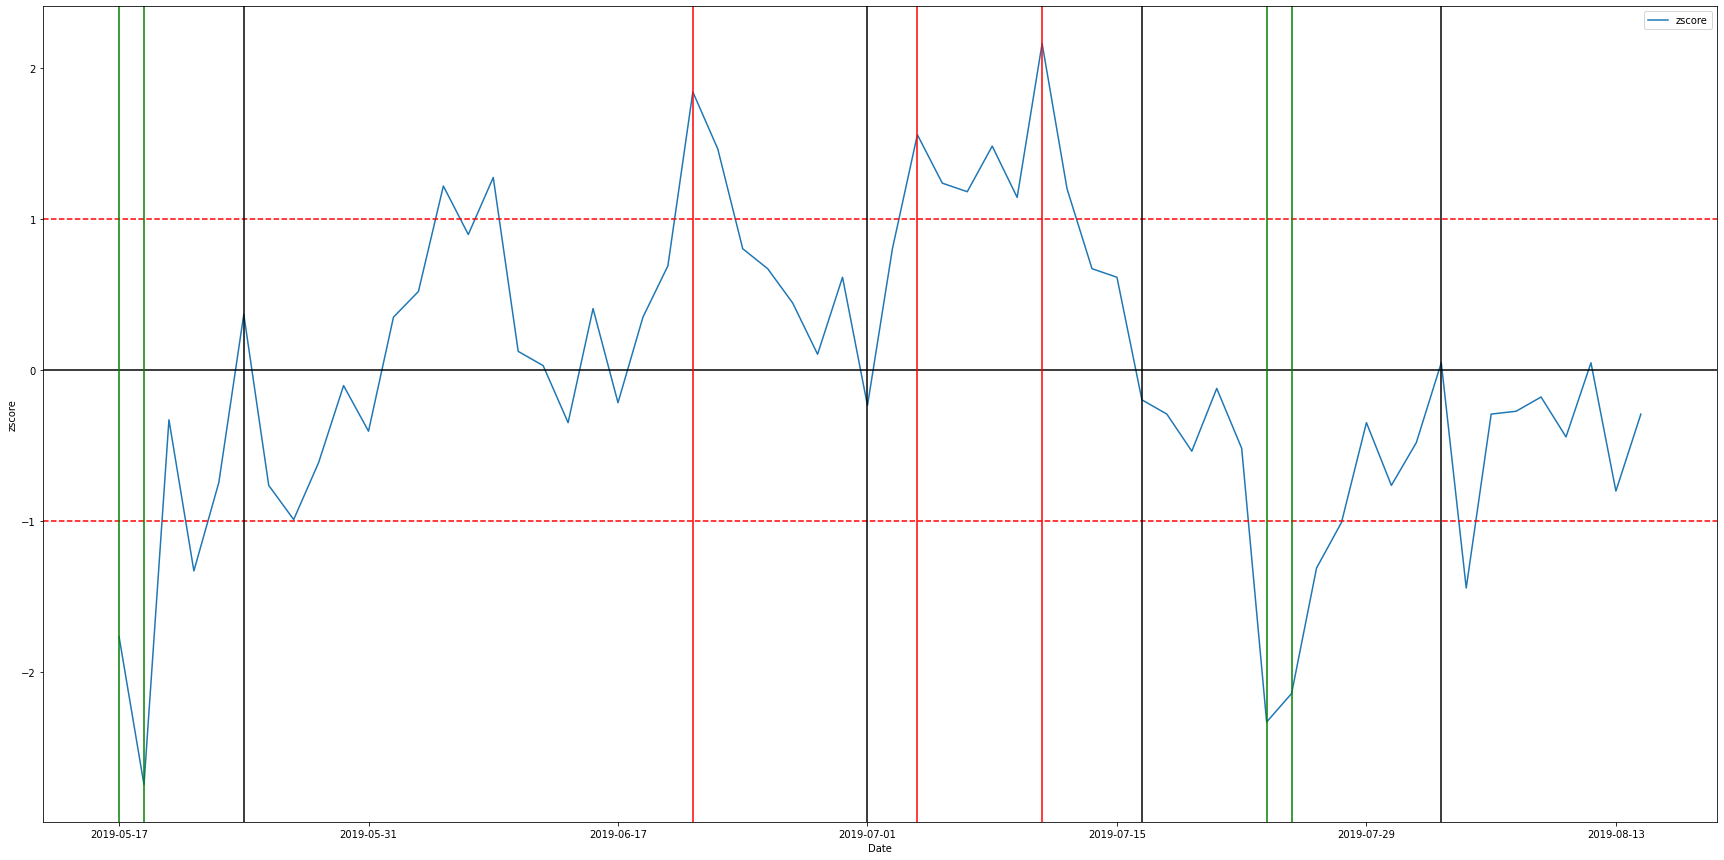

In [4]:
# Plotting the zscore of the Spread
orders_plt = orders_df.plot(x='Date', y='zscore', figsize=(30,15))

# Plotting the lines at mean, 1 and 2 std. dev.
orders_plt.axhline(0, c='black')
orders_plt.axhline(1, c='red', ls = "--")
orders_plt.axhline(-1, c='red', ls = "--")

# Extracting orders
Orders = orders_df['Orders']

# Plot vertical lines where orders are placed
for order in range(len(Orders)):
    
    if Orders[order] != "FLAT":
        
        # GREEN line for a long position
        if Orders[order] == "LONG":
            orders_plt.axvline(x=order, c = "green")
        
        # RED line for a short position
        elif Orders[order] == "SHORT":
            orders_plt.axvline(x=order, c = "red")
        
        # BLACK line for getting out of all positions at that point
        else:
            orders_plt.axvline(x=order, c = "black")

orders_plt.set_ylabel("zscore")

__In the figure above:__
- __Blue line__ - zscore of the Spread
- __Black horizontal line__ at 0 - Mean
- __Red dotted horizontal lines__ - at +1 and -1 standard deviations
- __Green vertical line__ - represents long position taken on that day
- __Red vertical line__ - represents short position taken on that day
- __Black vertical line__ - represents getting out of all open positions till that point


## 2.3 Visualize the close prices of both stocks

Text(0, 0.5, 'Price')

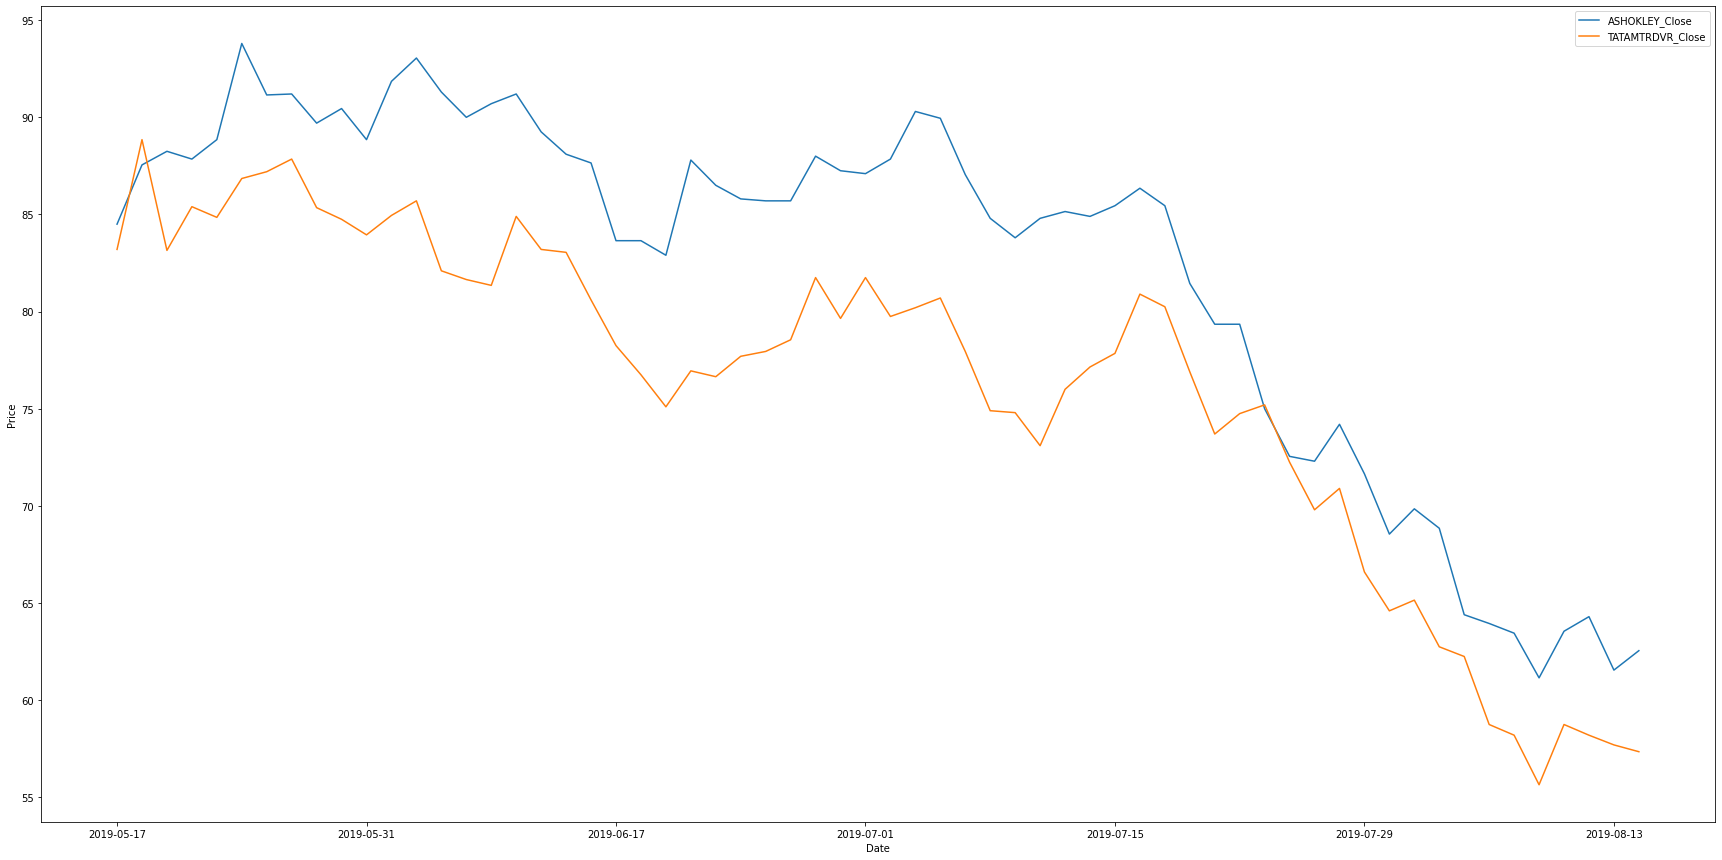

In [5]:
orders_df_plt = orders_df.plot(x='Date', y=['ASHOKLEY_Close', 'TATAMTRDVR_Close'], figsize=(30,15))
orders_df_plt.set_xlabel("Date")
orders_df_plt.set_ylabel("Price")

---

# 3. TATAMTRDVR Linear Regression Model

## 3.1. Get the Complete TATAMTRDVR dataset

In [6]:
tata_df = pd.read_csv("../../Storage/Companies_with_names_exchange/TATAMTRDVRNSE.csv")
tata_df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Company,Exchange
0,2017-01-02,309.350006,297.250000,301.000000,308.549988,894288.0,308.549988,TATAMTRDVR,NSE
1,2017-01-03,315.100006,306.600006,309.500000,308.399994,1558343.0,308.399994,TATAMTRDVR,NSE
2,2017-01-04,313.950012,308.549988,308.549988,310.250000,850924.0,310.250000,TATAMTRDVR,NSE
3,2017-01-05,324.000000,315.850006,317.000000,322.950012,1886492.0,322.950012,TATAMTRDVR,NSE
4,2017-01-06,325.299988,317.500000,323.000000,318.700012,700519.0,318.700012,TATAMTRDVR,NSE


- We can see that we have data from 2017-01-02

## 3.2. Get TATAMTRDVR training data

### 3.2.1 Get complete tata dataset

In [7]:
tata_df = tata_df.drop(columns=['High', 'Low', 'Open', 'Volume', 'Adj Close', 'Company', 'Exchange'])
tata_df.head()

,Date,Close
0,2017-01-02,308.549988
1,2017-01-03,308.399994
2,2017-01-04,310.250000
3,2017-01-05,322.950012
4,2017-01-06,318.700012


- We can see that the period where the stocks are correlated and co-integration starts from 2018-09-04.
- Thus the test data for which we need to make predictions is from 2018-09-04 to when the period ends at 2018-12-03.
- We take 1 year's worth of training data for our model, which means that the time period of our training data is from 2017-09-03 to 2018-09-04.


### 3.2.2. Crop dataset within training range

In [8]:
tata_df_train = tata_df[tata_df['Date'] >= '2017-09-03']
tata_df_train.head()

,Date,Close
166,2017-09-04,219.800003
167,2017-09-05,218.899994
168,2017-09-06,214.899994
169,2017-09-07,211.699997
170,2017-09-08,210.149994


In [9]:
tata_df_train = tata_df_train[tata_df_train['Date'] <= '2018-09-04']
tata_df_train.tail()

,Date,Close
412,2018-08-29,140.550003
413,2018-08-30,138.199997
414,2018-08-31,142.050003
415,2018-09-03,144.149994
416,2018-09-04,142.850006


### 3.2.3 Get the training data

In [10]:
tata_train = tata_df_train.copy()

In [11]:
tata_train = tata_train.reset_index(drop=True)
tata_train = tata_train.copy()
tata_train.head()

,Date,Close
0,2017-09-04,219.800003
1,2017-09-05,218.899994
2,2017-09-06,214.899994
3,2017-09-07,211.699997
4,2017-09-08,210.149994


In [12]:
tata_train_plot_copy = tata_train.copy()
tata_train.tail()

,Date,Close
246,2018-08-29,140.550003
247,2018-08-30,138.199997
248,2018-08-31,142.050003
249,2018-09-03,144.149994
250,2018-09-04,142.850006


In [13]:
tata_train = tata_train.drop(columns=['Date'])
tata_train = tata_train.values
tata_train

array([[219.80000305],
       [218.8999939 ],
       [214.8999939 ],
       [211.69999695],
       [210.1499939 ],
       [214.8500061 ],
       [222.1000061 ],
       [220.1000061 ],
       [230.        ],
       [228.30000305],
       [233.5       ],
       [241.3999939 ],
       [238.6000061 ],
       [233.19999695],
       [230.75      ],
       [228.80000305],
       [227.19999695],
       [223.        ],
       [221.3500061 ],
       [222.30000305],
       [233.19999695],
       [239.44999695],
       [241.1000061 ],
       [238.69999695],
       [238.55000305],
       [237.55000305],
       [235.6000061 ],
       [236.3500061 ],
       [238.        ],
       [245.        ],
       [246.1000061 ],
       [242.94999695],
       [241.5       ],
       [234.19999695],
       [231.        ],
       [234.69999695],
       [230.3500061 ],
       [237.94999695],
       [243.94999695],
       [240.8500061 ],
       [243.55000305],
       [242.25      ],
       [246.8999939 ],
       [259

In [14]:
len(tata_train)

251

## 3.3. Get TATAMTRDVR Test Data

In [15]:
tata_test = tata_df[(tata_df['Date'] >= '2018-09-04') & (tata_df['Date'] <= '2018-12-03')].copy()
tata_test.head()

,Date,Close
416,2018-09-04,142.850006
417,2018-09-05,142.949997
418,2018-09-06,144.199997
419,2018-09-07,147.750000
420,2018-09-10,146.750000


In [16]:
tata_test.tail()

,Date,Close
470,2018-11-27,98.099998
471,2018-11-28,95.550003
472,2018-11-29,96.050003
473,2018-11-30,93.750000
474,2018-12-03,95.300003


In [17]:
tata_test.reset_index(drop=True, inplace=True)
tata_test.index += 251
tata_test.head()

,Date,Close
251,2018-09-04,142.850006
252,2018-09-05,142.949997
253,2018-09-06,144.199997
254,2018-09-07,147.750000
255,2018-09-10,146.750000


In [18]:
tata_test_plot_copy = tata_test.copy()
tata_test = tata_test.drop(columns=['Date'])
tata_test = tata_test.values
tata_test

array([[142.8500061 ],
       [142.94999695],
       [144.19999695],
       [147.75      ],
       [146.75      ],
       [142.75      ],
       [142.3999939 ],
       [143.80000305],
       [140.6499939 ],
       [137.94999695],
       [136.69999695],
       [132.05000305],
       [128.05000305],
       [127.05000305],
       [123.05000305],
       [118.65000153],
       [116.55000305],
       [120.94999695],
       [120.65000153],
       [120.69999695],
       [117.34999847],
       [115.44999695],
       [101.55000305],
       [103.30000305],
       [101.84999847],
       [100.90000153],
       [101.44999695],
       [101.34999847],
       [100.15000153],
       [ 96.        ],
       [ 92.90000153],
       [ 94.84999847],
       [ 93.69999695],
       [ 91.30000305],
       [ 91.19999695],
       [ 95.94999695],
       [ 96.90000153],
       [ 97.69999695],
       [ 97.59999847],
       [102.55000305],
       [102.15000153],
       [104.30000305],
       [105.69999695],
       [105

In [19]:
len(tata_test)

59

## 3.4 Create and Train TATAMTRDVR Model

In [20]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(tata_train)
scaled_train_data

array([[0.68158216],
       [0.67439072],
       [0.64242907],
       [0.61685977],
       [0.60447461],
       [0.64202964],
       [0.69996013],
       [0.68397931],
       [0.76308434],
       [0.74950066],
       [0.79105078],
       [0.85417498],
       [0.83180193],
       [0.78865363],
       [0.76907714],
       [0.75349587],
       [0.74071116],
       [0.70715145],
       [0.69396732],
       [0.70155819],
       [0.78865363],
       [0.8385937 ],
       [0.85177796],
       [0.8326009 ],
       [0.83140238],
       [0.82341197],
       [0.80783069],
       [0.8138235 ],
       [0.82700763],
       [0.88294051],
       [0.89173002],
       [0.86656015],
       [0.85497407],
       [0.79664404],
       [0.77107475],
       [0.80063925],
       [0.76588103],
       [0.82660809],
       [0.87455056],
       [0.84978035],
       [0.87135444],
       [0.86096688],
       [0.89812225],
       [1.        ],
       [0.92648823],
       [0.87255295],
       [0.89732328],
       [0.852

In [21]:
X_train, y_train = [], []
for i in range(10,len(tata_train)):
    X_train.append(scaled_train_data[i-10:i,0])
    y_train.append(scaled_train_data[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

In [22]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

In [23]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=1, batch_size=1, verbose=2)

Epoch 1/1
 - 2s - loss: 0.0182


## 3.5. Get predictions

In [24]:
scaled_test_data = tata_test.reshape(-1,1)
scaled_test_data = scaler.transform(scaled_test_data)
scaled_test_data.shape

(59, 1)

In [25]:
X_test = []
for i in range(10, scaled_test_data.shape[0]):
    X_test.append(scaled_test_data[i-10:i,0])
X_test = np.array(X_test)
X_test

array([[ 0.06671999,  0.06751896,  0.07750697,  0.10587296,  0.09788255,
         0.0659209 ,  0.06312421,  0.07431086,  0.04914098,  0.0275669 ],
       [ 0.06751896,  0.07750697,  0.10587296,  0.09788255,  0.0659209 ,
         0.06312421,  0.07431086,  0.04914098,  0.0275669 ,  0.01757888],
       [ 0.07750697,  0.10587296,  0.09788255,  0.0659209 ,  0.06312421,
         0.07431086,  0.04914098,  0.0275669 ,  0.01757888, -0.01957648],
       [ 0.10587296,  0.09788255,  0.0659209 ,  0.06312421,  0.07431086,
         0.04914098,  0.0275669 ,  0.01757888, -0.01957648, -0.05153813],
       [ 0.09788255,  0.0659209 ,  0.06312421,  0.07431086,  0.04914098,
         0.0275669 ,  0.01757888, -0.01957648, -0.05153813, -0.05952854],
       [ 0.0659209 ,  0.06312421,  0.07431086,  0.04914098,  0.0275669 ,
         0.01757888, -0.01957648, -0.05153813, -0.05952854, -0.09149019],
       [ 0.06312421,  0.07431086,  0.04914098,  0.0275669 ,  0.01757888,
        -0.01957648, -0.05153813, -0.05952854

In [26]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)
len(closing_price)

49

In [27]:
print('Mean Absolute Error:', metrics.mean_absolute_error(tata_test[10:], closing_price))
print('Mean Squared Error:', metrics.mean_squared_error(tata_test[10:], closing_price))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(tata_test[10:], closing_price)))

Mean Absolute Error: 10.379049340072944
Mean Squared Error: 132.82691644661352
Root Mean Squared Error: 11.52505602791646


## 3.6. Visualize the predicitons vs test data

In [28]:
closing_price_df = pd.DataFrame(closing_price, columns=['price'])
closing_price_df.index += 260
closing_price = closing_price_df['price']
closing_price

260    141.452301
261    141.003159
262    140.239532
263    139.035568
264    137.329834
265    135.438095
266    133.521133
267    131.366638
268    129.134567
269    127.213058
270    125.601173
271    124.113274
272    122.923943
273    121.563644
274    119.963150
275    118.377327
276    116.879341
277    115.410751
278    113.650497
279    111.955391
280    110.237816
281    108.660645
282    107.220062
283    106.603325
284    105.772812
285    104.966545
286    104.312752
287    103.769722
288    103.395241
289    103.229027
290    103.531464
291    104.165741
292    104.831871
293    105.708069
294    106.791458
295    107.765259
296    108.241959
297    108.456947
298    108.489876
299    108.446236
300    108.119843
301    107.842056
302    107.469566
303    107.030403
304    106.644928
305    106.515770
306    106.466888
307    106.391418
308    106.118576
Name: price, dtype: float32

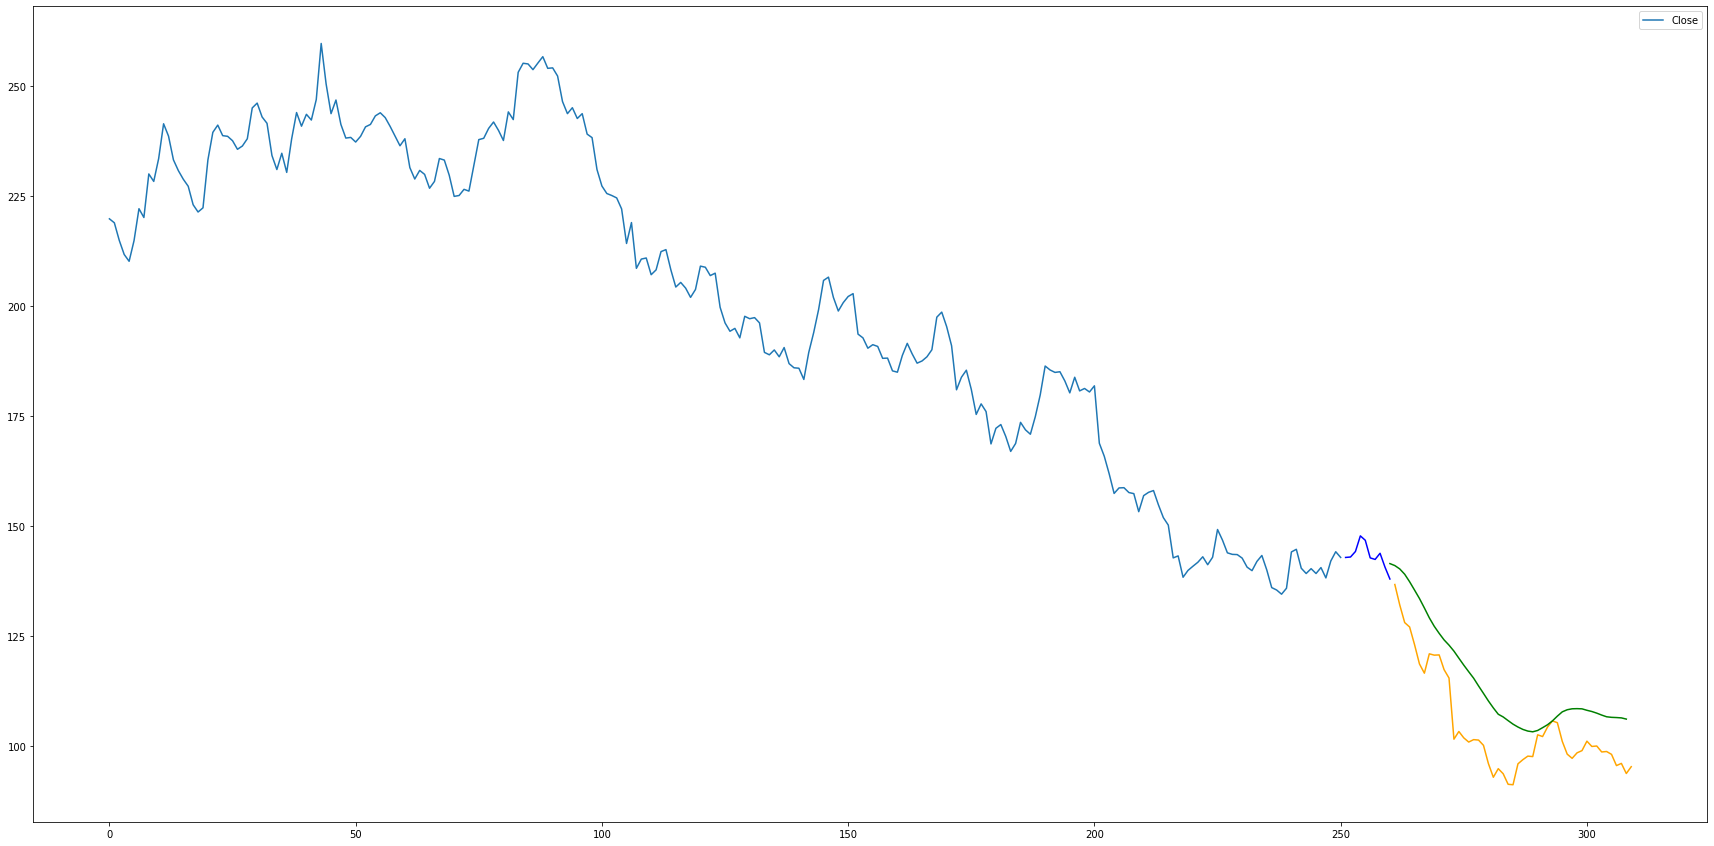

In [29]:
tata_model_plt = tata_train_plot_copy.plot(y=['Close'], figsize=(30,15))
tata_model_plt.plot(tata_test_plot_copy["Close"][:10], c='blue')
tata_model_plt.plot(tata_test_plot_copy["Close"][10:], c='orange')
tata_model_plt.plot(closing_price, c='green')

__In the graph above:__
- We can see the training data in blue
- The test data in orange
- The predictions made by the models in green

# 4. Put the results in a file

In [30]:
tata_predictions_df = pd.read_csv('Tata_predicitions.csv')
tata_predictions_df.head()

,Date,Actual_Close,Linear_regression_Close,ARIMA_Close,LSTM_Close
0,2019-05-17,83.199997,145.655884,128.025796,NaN
1,2019-05-20,88.849998,145.384391,127.611621,NaN
2,2019-05-21,83.150002,145.112899,129.149894,NaN
3,2019-05-22,85.400002,144.841406,123.576205,NaN
4,2019-05-23,84.849998,143.197024,120.873591,NaN


In [31]:
tata_predictions_df.tail()

,Date,Actual_Close,Linear_regression_Close,ARIMA_Close,LSTM_Close
57,2019-08-07,55.650002,115.945812,134.127795,103.194950
58,2019-08-08,58.750000,112.709611,136.600763,102.835846
59,2019-08-09,58.200001,NaN,NaN,NaN
60,2019-08-13,57.700001,NaN,NaN,NaN
61,2019-08-14,57.349998,NaN,NaN,NaN


In [32]:
closing_price_df.index -= 250
closing_price_df

,price
10,141.452301
11,141.003159
12,140.239532
13,139.035568
14,137.329834
15,135.438095
16,133.521133
17,131.366638
18,129.134567
19,127.213058


In [33]:
tata_predictions_df['LSTM_Close'] = closing_price_df['price']
tata_predictions_df

,Date,Actual_Close,Linear_regression_Close,ARIMA_Close,LSTM_Close
0,2019-05-17,83.199997,145.655884,128.025796,NaN
1,2019-05-20,88.849998,145.384391,127.611621,NaN
2,2019-05-21,83.150002,145.112899,129.149894,NaN
3,2019-05-22,85.400002,144.841406,123.576205,NaN
4,2019-05-23,84.849998,143.197024,120.873591,NaN
...,...,...,...,...,...
57,2019-08-07,55.650002,115.945812,134.127795,106.391418
58,2019-08-08,58.750000,112.709611,136.600763,106.118576
59,2019-08-09,58.200001,NaN,NaN,NaN
60,2019-08-13,57.700001,NaN,NaN,NaN


In [34]:
tata_predictions_df.to_csv('Tata_predicitions.csv', index=False)